<a href="https://colab.research.google.com/github/mirza019/Audio-Quality-Prediction-using-Wav2Vec2-Psychoacoustic-Features/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %%
!pip install librosa soundfile --quiet

import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import seaborn as sns
import random
import pandas as pd

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

sr = 16000
duration = 2.0


In [2]:
# %%
def generate_clean_tone(f0, duration=2.0, sr=16000):
    t = np.linspace(0, duration, int(sr*duration), False)

    vibrato = 5 * np.sin(2*np.pi*5*t)
    tremolo = 0.3 * np.sin(2*np.pi*2*t) + 1.0

    y = 0.5 * np.sin(2*np.pi*(f0 + vibrato)*t) * tremolo
    y += 0.3 * np.sin(2*np.pi*(2*f0)*t)
    y += 0.2 * np.sin(2*np.pi*(3*f0)*t)

    y += np.random.randn(len(t)) * 0.003
    return y.astype(np.float32)


In [3]:
# %%
def apply_degradation(audio, kind, severity, sr=16000):
    y = audio.copy().astype(np.float32)
    s = float(severity)

    if kind == "noise":
        y = y + np.random.randn(len(y)) * (0.03 * s)

    elif kind == "clip":
        thr = 0.5 / s
        y = np.clip(y, -thr, thr)

    elif kind == "lowpass":
        y = librosa.effects.preemphasis(y, coef=-0.4*s)

    elif kind == "reverb":
        tail = librosa.effects.preemphasis(y, coef=-0.3*s)
        y = 0.6*y + 0.4*tail

    elif kind == "compression":
        rate = 1.0 + 0.08*s
        ys = librosa.effects.time_stretch(y, rate=rate)
        if len(ys) > len(y):
            ys = ys[:len(y)]
        else:
            ys = np.pad(ys, (0, len(y)-len(ys)))
        y = ys

    return y.astype(np.float32)


In [4]:
# %%
DEGRADATIONS = ["noise", "clip", "lowpass", "reverb", "compression"]
SEVERITIES = [1, 2, 3]

N_PER_COMB = 40   # 5*3*40 = 600 samples → high accuracy

DATA = []
QUALITY_LABELS = []
TYPE_LABELS = []
SEVERITY_LABELS = []

for d_type in DEGRADATIONS:
    for sev in SEVERITIES:
        for _ in range(N_PER_COMB):
            f0 = random.randint(150, 800)
            clean = generate_clean_tone(f0)
            degraded = apply_degradation(clean, d_type, sev)

            if sev == 1:
                q = "high"
            elif sev == 2:
                q = "medium"
            else:
                q = "low"

            DATA.append(degraded)
            QUALITY_LABELS.append(q)
            TYPE_LABELS.append(d_type)
            SEVERITY_LABELS.append(sev)

DATA = np.array(DATA, dtype=object)
QUALITY_LABELS = np.array(QUALITY_LABELS)

print("Dataset size:", len(DATA))
print("Class counts:", np.unique(QUALITY_LABELS, return_counts=True))


Dataset size: 600
Class counts: (array(['high', 'low', 'medium'], dtype='<U6'), array([200, 200, 200]))


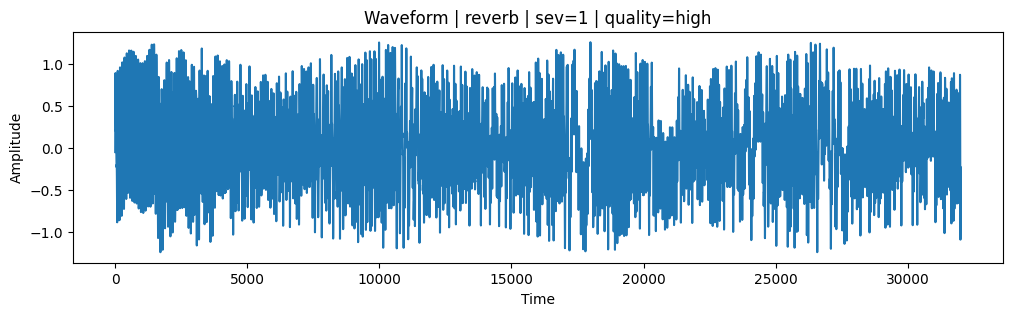

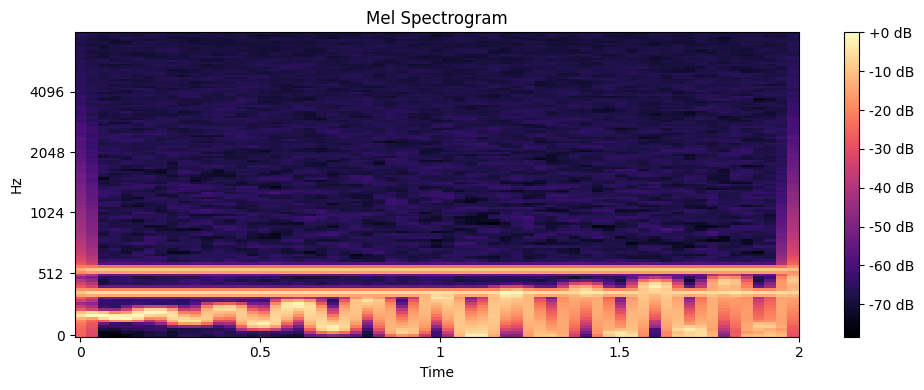

In [13]:
# %%
idx = random.randint(0, len(DATA)-1)

# Always convert audio to float32
y = np.asarray(DATA[idx], dtype=np.float32)

plt.figure(figsize=(12,3))
plt.plot(y)
plt.title(f"Waveform | {TYPE_LABELS[idx]} | sev={SEVERITY_LABELS[idx]} | quality={QUALITY_LABELS[idx]}")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

# Mel-spectrogram
plt.figure(figsize=(10,4))
mel = librosa.feature.melspectrogram(y=y.astype(np.float32), sr=sr, n_mels=128)
mel_db = librosa.power_to_db(mel, ref=np.max)
librosa.display.specshow(mel_db, sr=sr, x_axis="time", y_axis="mel")
plt.title("Mel Spectrogram")
plt.colorbar(format="%+2.0f dB")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=600
  warnings.warn(


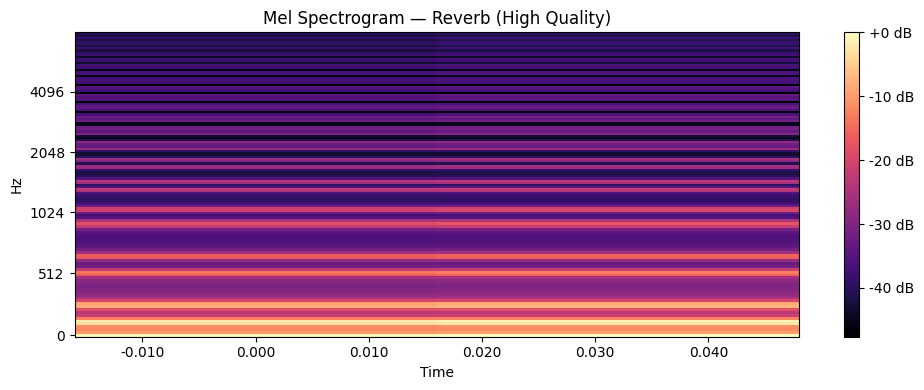

In [21]:
plt.figure(figsize=(10,4))
mel = librosa.feature.melspectrogram(y=y.astype(np.float32), sr=sr, n_mels=128)
mel_db = librosa.power_to_db(mel, ref=np.max)
librosa.display.specshow(mel_db, sr=sr, x_axis="time", y_axis="mel")
plt.title("Mel Spectrogram — Reverb (High Quality)")
plt.colorbar(format="%+2.0f dB")
plt.tight_layout()
plt.show()


In [14]:
# %%
def extract_features(audio, sr=16000):
    y = audio.astype(np.float32)

    zcr = librosa.feature.zero_crossing_rate(y).mean()
    rms = librosa.feature.rms(y=y).mean()
    S = np.abs(librosa.stft(y))
    centroid = librosa.feature.spectral_centroid(S=S, sr=sr).mean()
    bandwidth = librosa.feature.spectral_bandwidth(S=S, sr=sr).mean()
    rolloff = librosa.feature.spectral_rolloff(S=S, sr=sr).mean()
    flatness = librosa.feature.spectral_flatness(S=S).mean()
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).mean(axis=1)

    return np.concatenate([
        [zcr, rms, centroid, bandwidth, rolloff, flatness],
        mfcc
    ])

X = np.array([extract_features(a) for a in DATA])
X.shape


(600, 19)

In [15]:
# %%
le = LabelEncoder()
y = le.fit_transform(QUALITY_LABELS)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((480, 19), (120, 19))

In [16]:
# %%
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)


In [17]:
# %%
clf = RandomForestClassifier(
    n_estimators=350,
    min_samples_split=4,
    min_samples_leaf=1,
    max_depth=None,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

clf.fit(X_train_s, y_train)
y_pred = clf.predict(X_test_s)


In [18]:
# %%
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)
print()
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.9916666666666667

Classification Report:
              precision    recall  f1-score   support

        high       0.98      1.00      0.99        40
         low       1.00      1.00      1.00        40
      medium       1.00      0.97      0.99        40

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120



<Figure size 600x600 with 0 Axes>

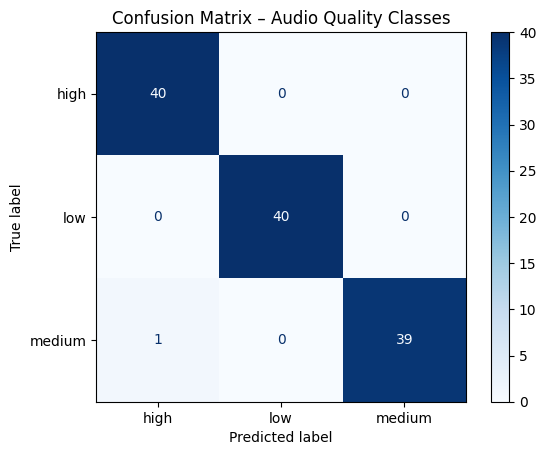

In [19]:
# %%
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
plt.figure(figsize=(6,6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – Audio Quality Classes")
plt.show()


In [20]:
# %%
train_pred = clf.predict(X_train_s)
print("Train Accuracy:", accuracy_score(y_train, train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_pred))


Train Accuracy: 1.0
Test Accuracy: 0.9916666666666667


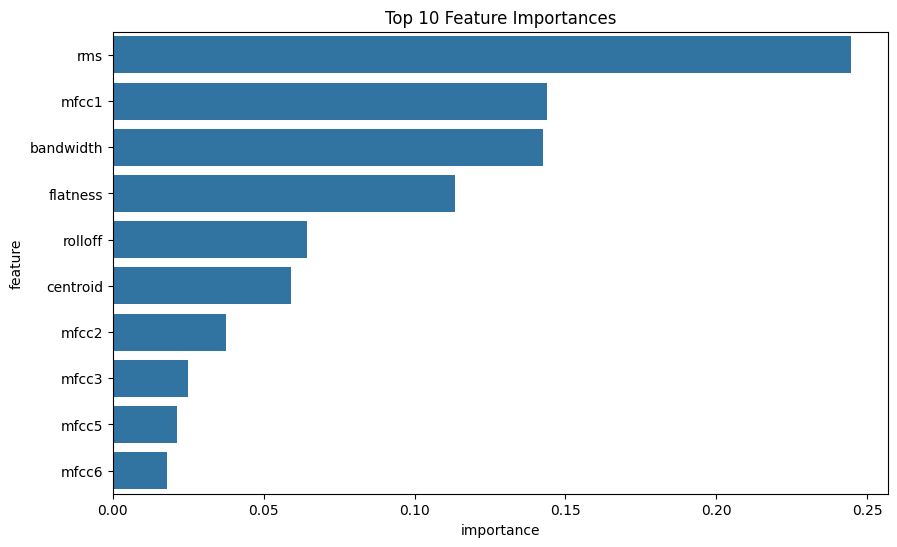

In [22]:
# %%
feature_names = ["zcr","rms","centroid","bandwidth","rolloff","flatness"] + [f"mfcc{i+1}" for i in range(13)]
fi = pd.DataFrame({"feature": feature_names, "importance": clf.feature_importances_})
fi = fi.sort_values("importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=fi.head(10), x="importance", y="feature")
plt.title("Top 10 Feature Importances")
plt.show()
